## Pregunta 2: Redes recurrentes sobre texto

> **Parte a)**

In [1]:
import numpy as np
from collections import Counter
import operator
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from math import floor

from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
link = 'https://github.com/csaldias/tarea2-RedesNeuronales/raw/master/entity-annotated-corpus/ner.tar.gz'
df_ner = pd.read_csv(link, compression='gzip', error_bad_lines=False, encoding='Latin-1')
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [6]:
df_ner.head()

,./._ner.csv,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0.0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1.0,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2.0,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3.0,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4.0,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


La columna *word* contiene a la palabra exacta, en cambio *lemma* simplifica la entrada, ignorando mayúsculas y utilizando la preposición que identifica la palabra y su contenido, en lugar de la palabra completa.

In [11]:
dataset = df_ner.loc[:, ["lemma", "pos", "tag", "prev-iob"]]

Las definiciones de cada columna son:

* *lemma*: Indica el 'tema' de la palabra, es decir, el significado general de la palabra en base al prefijo. (I.e. 'demonstr' para representar 'demonstrators' y 'demonstration'.)
* *pos*: Anotación 'Part-of-speech'. Significa la función de la palabra. (Verbo, sustantivo, etc).
* *tag*: Tag IOB, que indica si la palabra corresponde a una porción interna, externa o inicial (Inside-Outside-Beginning respectivamente). 
* *prev-iob*: Tag IOB de la palabra que precede a la palabra actual.

In [11]:
dataset.shape

(1050794, 4)

La variable *dataset* sostiene 4 columnas de datos, con 1,050,794 palabras.

In [12]:
dataX,dataY = [],[]
#uniques
lemmas,labels = set(), set()
sentence= []
label_sentence = []

for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(label_sentence))
        sentence= []
        label_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[1])
    sentence.append(fila[0])#add lemma
    label_sentence.append(fila[1]) #POS o TAG
#data to  array
dataX = np.asarray(dataX[1:])
dataY = np.asarray(dataY[1:])

In [13]:
print(dataX.shape,dataY.shape)

(48081,) (48081,)


Se posee un total de 48,081 entradas distintas (oraciones), cada una de estas con una cantidad variable de palabras.

> **Parte b)**

Se procede a graficar un histograma que presenta la probabilidad de que una palabra sea de un largo particular.

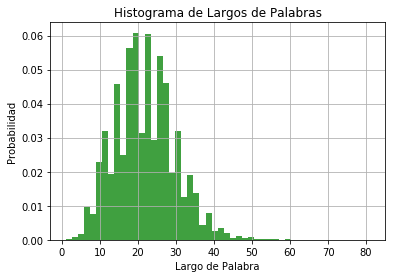

In [8]:
length = lambda x: len(x)
vfunc = np.vectorize(length)
word_lenghts = vfunc(dataX)

n, bins, patches = plt.hist(word_lenghts, 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Largo de Palabra')
plt.ylabel('Probabilidad')
plt.title('Histograma de Largos de Palabras')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

La forma del gráfico aparenta una distribución normal o gamma.

La ley de Zipf sostiene que la frecuencia con que una palabra aparece en un conjunto de oraciones es inversamente proporcional al lugar que ocupa en la tabla de frecuencia. Por ejemplo, la palabra que aparece en segundo lugar con mayor frecuencia, aparecerá la mitad de las veces que aparece la que ocupa el primer lugar.

Es decir, se tiene la siguiente función $$y=\frac{1}{x}$$
Aplicando logaritmo a la ecuación completa $$log(y)=-log(x)$$
Se procede a graficar esta función.

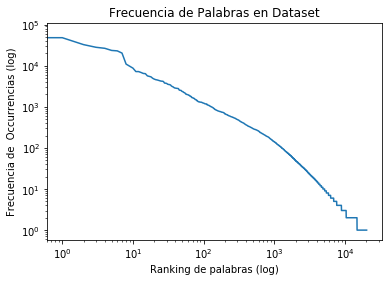

In [9]:
word_freq = {}
for i in dataX:
    for j in i:
        if j in word_freq:
            word_freq[j] += 1
        else:
            word_freq[j] = 1

sorted_freq = (sorted(word_freq.items(), key = operator.itemgetter(1), reverse=True))

just_the_occur = []
just_the_rank = []

entry_num = 0
for entry in sorted_freq:
    just_the_rank.append(entry_num)
    entry_num += 1
    just_the_occur.append(entry[1])

plt.title("Frecuencia de Palabras en Dataset")
plt.ylabel("Frecuencia de  Occurrencias (log)")
plt.xlabel("Ranking de palabras (log)")
plt.loglog(
    just_the_rank,
    just_the_occur,
    basex=10
)
plt.show()

A pesar de ser una curva, el gráfico se aproxima a la recta con pendiente negativa que presenta la ley de Zipf por lo que se puede decir que se cumple.

> **Parte c)**

Se calcula la oración de largo máximo.

In [13]:
max_length = 0
for palabra in dataX:
    max_length = max(len(palabra), max_length)
print(max_length)

81


In [14]:
#lemma -> ENDLEMMA
lemmas.add("ENDLEMMA")
#labels -> ENDLABELS
labels.add("ENDLABELS")
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[pos] for pos in pos_tags ] for pos_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)

In [18]:
print(n_lemmas,n_labels)

20244 42


Hay un total de 20,244 lemmas distintos, y 42 tags Part-of-speech.

In [15]:
X = sequence.pad_sequences(dataX,maxlen=max_length,padding='post',value=lemma2idx["ENDLEMMA"]) 
y = sequence.pad_sequences(dataY,maxlen=max_length,padding='post',value=lab2idx["ENDLABELS"])

En las variables *X* e *y* se almacenan los *lemmas* y *pos* de cada palabra respectivamente, por lo que la red neuronal tiene la labor de inferir el POS (propósito en el contexto de la oración) de cada palabra en base a su lemma.

In [14]:
print(X[0])

[14705 14946 15016  2720  8391 12076 14195 17423  6854 19972 16202  2895
  8724 16244 10224 19972  2741 14946 17447 16780  3072  6919   900 17155
 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983
 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983
 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983
 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983 15983
 15983 15983 15983 15983 15983 15983 15983 15983 15983]


In [15]:
print(y[0])

[15 12 15  8 30 12  5 20 25 18  2 12  5 28 25 18  2 12  9 15 12 18  2  6
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23]


> **Parte d)**

Esta parte fue cubierta en el ítem c).

Respecto a como la red neuronal leerá la entrada, no hace diferencia mientras se mantenga consistente la elección de rellenar sólo el inicio o el final. Sin embargo si es que consideramos el aprendizaje del modelo, la posición relativa a la oración es información relevante que se pierde si se llena desde el inicio, por lo tanto conviene rellenar al final.

> **Parte e)**

In [16]:
X.shape

(48081, 81)

La entrada de la red neuronal son oraciones con un máximo de 81 palabras.

In [11]:
y.shape

(48081, 81)

In [16]:
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [19]:
y.shape

(48081, 81, 42)

En efecto, ahora cada una de las oraciones tiene una entrada asociada a la anotación POS (las 42 vistas en el ítem **c)**). Utilizando este acercamiento, se ignora la relación ordinal de la anotación POS para al aprendizaje (es decir, la magnitud de la anotación no es relevante). En lugar de eso, utilizar un *one-hot vector* como salida permite la clasificación parcial en varias clases.

Los conjuntos de entrenamiento y testing fueron explícitamente separadas en las variables *_train* y *_test* respectivamente.

In [20]:
y_test.shape

(14425, 81, 42)

In [21]:
X_test.shape

(14425, 81)

> **Parte f)**

Como se mostró en el ítem anterior, los datos de entrada tiene forma $14,425\times 81$, correspondientes a las 14,425 oraciones de un máximo de 81 palabras, sin embargo su dimensionalidad cambia tras transitar por la capa de *embedding*. Particularmente *Word-embedding* busca aprender del contexto de las palabras, tomando en consideración cosas como la posición de esta o su forma. Para llevar registro de esto, la capa de embedding lleva la representación discreta de la oración a un vector de carácter continuo; no se computan operaciones matemáticas si no que es más parecido al proceso de hashing. 

Por otro lado, las compuertas LSTM (*Long short-term memory*) se encargan de recordar valores por un período de tiempo arbitrario. Pueden ser interpretadas como regularizadores porque mitigan los problemas de gradiente desvaneciente y explosiva.

Se compila el modelo del enunciado.

In [27]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_length))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_4 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_3 (Dense)              (None, 81, 42)            4242      
Total params: 705,250
Trainable params: 705,250
Non-trainable params: 0
_________________________________________________________________


En primera instancia, la entrada de $14,425\times81$ es llevada a un espacio de $14,425\times81\times32$. La dimensión adicional, el $32$, corresponde a la representación vectorial de lo que antes correspondía a un valor continuo.

Existen un total de $20,244$ lemmas distintos, por lo que se debe construir un tabla de $20,244\times32$, equivalente a una tabla de hashing. Los pesos de esta tabla son los entrenables y correspondientes a los $647,808$ parámetros entrenables.

Las unidades LSTM tienen 3 compuertas:

* Input
* Output
* 'Forget'

Adicionalmente poseen una unidad de memoria, por lo que al menos hay 4 parámetros que entrenar por cada una de las unidades. Cada una de estas unidades están conectadas a todas las unidades $n$ (las unidades del paso anterior, correspondiente a la conección recurrente de la red) y conectadas a las dimensiones $m$ del vector de embedding.

Considerando el bias de las 100 unidades, el número de parámetros entrenables son $$4\times(nm+n^{2}+n)=4\times(100\times 32+100^{2}+100)=53,200$$

Finalmente los parámetros última capa son sencillamente la conexión entre las 100 unidades LSTM y las 42 unidades de la capa densa, considerando el bias.$$42\times100+42=4,242$$ 

Se entrena la red neuronal.

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 26s 770us/step - loss: 1.0896 - acc: 0.7491 - val_loss: 0.7573 - val_acc: 0.7961
Epoch 2/3
33656/33656 [==============================] - 25s 742us/step - loss: 0.5970 - acc: 0.8401 - val_loss: 0.4115 - val_acc: 0.8877
Epoch 3/3
33656/33656 [==============================] - 25s 731us/step - loss: 0.2883 - acc: 0.9224 - val_loss: 0.1927 - val_acc: 0.9505


Para ser solamente 3 epochs, la red le tomó un tiempo considerable debido a la cantidad de parámetros involucrados. 

In [30]:
print("Loss: {:.4f}".format(scores[0]))
print("Accuracy: {:.2f}%".format(scores[1]*100))

Loss: 0.1927
Accuracy: 95.05%


Aún así, la red logra un excelente desempeño, con un precisión del 95.05% en las anotaciones POS.

> **Parte g)**

In [48]:
n_vector = 5
embedding_vectors = np.logspace(start=0, stop=4, num=n_vector, base=10).astype(int)
scores_list = {}
exec_time = {}
for embedding_vector in embedding_vectors:
    print("Usando embedding_vector={}...".format(embedding_vector))
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_length))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dense(n_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    start = timer()
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    end = timer()
    scores = model.evaluate(X_test, y_test, verbose=0)
    scores_list[embedding_vector] = scores
    exec_time[embedding_vector] = end - start

Usando embedding_vector=1...
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 120s 4ms/step - loss: 1.1957 - acc: 0.7346 - val_loss: 0.8950 - val_acc: 0.7520
Epoch 2/3
22144/33656 [==================>...........] - ETA: 36s - loss: 0.8336 - acc: 0.766933656/33656 [==============================] - 117s 3ms/step - loss: 0.8161 - acc: 0.7705 - val_loss: 0.7686 - val_acc: 0.7812
Epoch 3/3
33656/33656 [==============================] - 116s 3ms/step - loss: 0.7283 - acc: 0.7971 - val_loss: 0.6716 - val_acc: 0.8189
Usando embedding_vector=10...
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
 9600/33656 [=======>......................] - ETA: 1:24 - loss: 1.6753 - acc: 0.711833656/33656 [==============================] - 123s 4ms/step - loss: 1.1315 - acc: 0.7407 - val_loss: 0.8126 - val_acc: 0.7725
Epoch 2/3
33656/33656 [==============================] - 121s 4ms/step - loss: 0.7442 - acc: 0.7926 - val_loss: 0.6635 - val

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 202440000 elements. This may consume a large amount of memory.
  num_elements)


Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 3851s 114ms/step - loss: 0.2587 - acc: 0.9385 - val_loss: 0.0851 - val_acc: 0.9734
Epoch 2/3
27392/33656 [=======================>......] - ETA: 10:34 - loss: 0.0693 - acc: 0.977533656/33656 [==============================] - 3841s 114ms/step - loss: 0.0680 - acc: 0.9778 - val_loss: 0.0675 - val_acc: 0.9778
Epoch 3/3
33656/33656 [==============================] - 3871s 115ms/step - loss: 0.0522 - acc: 0.9823 - val_loss: 0.0615 - val_acc: 0.9795


Referencias:

https://www.digitalocean.com/community/tutorials/how-to-graph-word-frequency-using-matplotlib-with-python-3


In [54]:
for index in embedding_vectors:
    print("Embedding Vector: {}\tLoss: {:.4f}, Accuracy: {:.2f}%, Tiempo: {:.3f} min".format(index, scores_list[index][0], scores_list[index][1]*100, exec_time[index]/60))

Embedding Vector: 1	Loss: 0.6716, Accuracy: 81.89%, Tiempo: 5.905 min
Embedding Vector: 10	Loss: 0.4287, Accuracy: 86.74%, Tiempo: 6.090 min
Embedding Vector: 100	Loss: 0.1032, Accuracy: 97.00%, Tiempo: 7.617 min
Embedding Vector: 1000	Loss: 0.0699, Accuracy: 97.71%, Tiempo: 24.056 min
Embedding Vector: 10000	Loss: 0.0615, Accuracy: 97.95%, Tiempo: 192.750 min


Aumentando la dimensión del vector de embedding, se consigue una mejor precisión de tagging y menor pérdida tras ser entrenado. Los tiempos aumentan conforme se aumenta la dimensionalidad del vector, sin embargo tras utilizar un vector con 100 dimensiones, la precisión del modelo no mejora mucho.

Si bien los números del vector de embedding no tienen una interpretación directa más que corresponden a información de posicionamiento y distancia de los lemmas, aumentar las dimensiones implica almacenar más información. Bajo este marco, uno podría argumentar que utilizar las mismas dimensiones que el largo de las palabras lograría almacenar la mayor cantidad de información espacial.

In [46]:
embedding_vector = 81
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_length))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Loss: {:.4f}".format(scores[0]))
print("Accuracy: {:.2f}%".format(scores[1]*100))

Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 26s 770us/step - loss: 1.0208 - acc: 0.7631 - val_loss: 0.6989 - val_acc: 0.8267
Epoch 2/3
33656/33656 [==============================] - 25s 730us/step - loss: 0.4194 - acc: 0.8929 - val_loss: 0.2015 - val_acc: 0.9536
Epoch 3/3
33656/33656 [==============================] - 25s 729us/step - loss: 0.1350 - acc: 0.9648 - val_loss: 0.1076 - val_acc: 0.9692
Loss: 0.1076
Accuracy: 96.92%


En efecto, utilizando las mismas dimensiones, se logra una precisión muy cercana al máximo de precisión alcanzada por el vector de embedding 10,000 dimensiones.

> **Parte h)**

In [31]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_length))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
scores = model.evaluate(X_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_5 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 81, 42)            4242      
Total params: 705,250
Trainable params: 705,250
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 27s 803us/step - loss: 1.0863 - acc: 0.7449 - val_loss: 0.7652 - val_acc: 0.7837
Epoch 2/3
33656/33656 [==============================] - 25s 735us/step - loss: 

In [32]:
print("Loss: {:.4f}".format(scores[0]))
print("Accuracy: {:.2f}%".format(scores[1]*100))

Loss: 0.1991
Accuracy: 94.91%


Utilizar dropout no mejora el desempeño de la red. Esto puede deberse a que dropout ignora activaciones, es decir, pierde información durante el entrenamiento, esencialmente 'olvidándola'. Si bien esto resuelve otros problemas en redes propensas a overfitting, dropout genera el efecto contrario a las unidades LSTM, por lo que mitiga el efecto positivo que estas unidades podrían producir.

> **Parte i)**

Un LSTM bidireccional funciona de manera parecida a los convencionales, sólo que ahora considera inputs tanto de iteraciones pasadas como posteriores. La justificación detrás de este acercamiento es que en casos como reconocimiento de habla, donde el contexto del enunciado entero provee de significado a las palabras, contrario a la interpretación lineal.

Primero se analizará a grandes rasgos el modelo.

In [53]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_length))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode=mode))
model.add(Dense(n_labels, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 81, 200)           106400    
_________________________________________________________________
dense_16 (Dense)             (None, 81, 42)            8442      
Total params: 762,650
Trainable params: 762,650
Non-trainable params: 0
_________________________________________________________________


Utilizando una capa bidireccional, esta vez se tiene el doble parámetros entrenables en esta capa, y de unidades LSTM. Cada par de estas unidades corresponden a una unidad compuesta, cuyo estado final es determinado por el método de unión (o *merge_mode* en este caso).

A continuación se presenta el entrenamiento utilizando todos los métodos disponibles.

In [54]:
embedding_vector = 32
scores_list = {}
exec_times = {}
for mode in ["sum", "mul", "ave", "concat"]:
    print("Usando modo "+mode+"...")
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_length))
    layer_lstm = LSTM(units=100,return_sequences=True)
    model.add(Bidirectional(layer_lstm,merge_mode=mode))
    model.add(Dense(n_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    start = timer()
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128,verbose=0)
    end = timer()
    scores = model.evaluate(X_test, y_test, verbose=0)
    scores_list[mode] = scores
    exec_times[mode] = end - start

Usando modo sum...
Usando modo mul...
Usando modo ave...
Usando modo concat...


In [55]:
for mode in ["sum", "mul", "ave", "concat"]:
    print("Modo: {}\tLoss: {:.4f}, Accuracy: {:.2f}%, Tiempo: {:.3f} min".format(mode, scores_list[mode][0], scores_list[mode][1]*100, exec_times[mode]/60))

Modo: sum	Loss: 0.1078, Accuracy: 96.81%, Tiempo: 2.322 min
Modo: mul	Loss: 0.1422, Accuracy: 96.15%, Tiempo: 2.307 min
Modo: ave	Loss: 0.2218, Accuracy: 94.37%, Tiempo: 2.312 min
Modo: concat	Loss: 0.1216, Accuracy: 96.57%, Tiempo: 2.308 min


Empíricamente, los métodos de suma, multiplicación y concadenación mejoran aproximadamente un 1% la precisión respecto a la red neuronal unidireccional, en especial la suma. Por otro lado utilizar promedio empeora su desempeño.

> **Parte j)**

In [56]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_length))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128,verbose=0)

In [77]:
i=12
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(list(lemmas)[w],list(labels)[pred]))

Lemma          : Pred
earlier        : RB
today          : NN
,              : ,
white          : NNP
hous           : NNP
spokeswoman    : NN
dana           : NNP
perino         : NNP
said           : VBD
mr.            : NNP
bush           : NNP
will           : MD
cooper         : VB
with           : IN
u.s.           : NNP
attorney       : NNP
general        : NNP
michael        : NNP
mukasey        : NNP
in             : IN
the            : DT
investig       : NN
.              : .
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLABELS
ENDLEMMA       : ENDLA

Lo más obvio a la vista es que la red neuronal identifica correctamente los caracteres de relleno ENDLEMMA y los clasifica como ENDLABELS. Se identifica correctamente *earlier* como adverbio (indica circunstancia), sustantivos propios (es decir, palabras que identifican personas/lugar y que son escritas con mayúsculas), *spokeswoman* como sustantivo, verbos en sus tiempos correctos (*said* como verbo en tiempo pasado o *cooperate* como verbo en su forma base), *will* verbo modal (que indican disposición) y puntuaciones o símbolos como las comas y puntos.

Al menos a partir de este ejemplo, la clasificación parece no tener ningún fallo, reflejando el nivel de precisión anteriormente informado (96% aproximadamente).

> **Parte k)**

La razón por la que se cargan las palabras es porque los lemmas no contienen la palabra completa, si no abreviaciones que representan el tópico de la palabra. Dado que se pretende predecir un carácter a la vez, es necesario contar con la palabra exacta (salvo las mayúsculas).

In [17]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 5 
sentences = []
next_chars = []
size = int(len(text)*1) #todo el corpus, porque hace frío y necesito una estufa en lugar de notebook
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

total chars: 72
nb sequences: 1213495


Bajo el razonamiente que utilizando mayor cantidad de datos significa un mejor modelo, se utiliza el corpus completo del texto.

> **Parte l)**

Luego se generan los datos utilizados por el modelo.

In [24]:
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]

Para el padding, se llenará utilizando el carácter nulo (*null_character*) que se dió en el código del ítem anterior. Además se separará nuevamente en un conjunto de entrenamiento y uno de testeo.

In [25]:
X = sequence.pad_sequences(dataX,maxlen=maxlen+1,padding='pre',value=char_indices[null_character]) 
y = np.asarray([to_categorical(i, num_classes=len(char_indices)) for i in dataY])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

Luego se define el modelo con CuDNNGRU (capa parecida a LSTM pero computacionalmente más eficiente, que sólo utiliza la tarjeta gráfica).

In [59]:
from keras.layers import CuDNNGRU,GRU
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

> **Parte m)**

Se definen las funciones del enunciado y una función adicional para poder visualizar el desempeño durante entrenamiento.

In [3]:
def predict_next_char(model, sentence, diversity=1.0):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds)
    return indices_char[next_index]
import random,sys
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return
def resumenGrafico(history):
    if ('acc' in history.history):
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
        ax = axes.flatten()
        ax[0].plot(history.history['loss'])
        ax[0].plot(history.history['val_loss'])
        ax[0].set_title('Perdida del modelo')
        ax[0].set_ylabel('Perdida')
        ax[0].set_xlabel('Epoch')
        ax[0].legend(['Train', 'Val'], loc='upper left')
        ax[1].plot(history.history['acc'])
        ax[1].plot(history.history['val_acc'])
        ax[1].set_title('Precision del modelo')
        ax[1].set_ylabel('Precision')
        ax[1].set_xlabel('Epoch')
        ax[1].legend(['Train', 'Val'], loc='upper left')
    else:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Perdida del modelo')
        plt.ylabel('Perdida')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Luego se entrena el modelo.

In [30]:
#Se viene
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),batch_size=256,epochs=25, callbacks=[print_callback])

Train on 849446 samples, validate on 364049 samples
Epoch 1/25
849446/849446 [==============================] - 192s 226us/step - loss: 2.0121 - acc: 0.4132 - val_loss: 1.5263 - val_acc: 0.5504

----- Generating text after Epoch: 0
----- Generating with seed: "ement appears to have averted a showdown"
ement appears to have averted a showdown kush offialial a precol fills ary that humber a "re utow 's forulo, annaule at a romation na ho-loy whas he pare that u.s. bills of chorgra inforders . the pracect groups after brrugisies iraq . at imaq , under the t're jotairy . the fire-on eart qyincy ip ig hosial state replagedey caeranest tuleby the eadly presenters of the yaila in a nat of jorday u.s. mixinter of that that monday infurtt busEpoch 2/25
849446/849446 [==============================] - 192s 226us/step - loss: 1.4460 - acc: 0.5740 - val_loss: 1.3253 - val_acc: 0.6086

----- Generating text after Epoch: 1
----- Generating with seed: "he white house to discuss a peacekeeping"
he whi

849446/849446 [==============================] - 186s 219us/step - loss: 1.1248 - acc: 0.6585 - val_loss: 1.2035 - val_acc: 0.6437

----- Generating text after Epoch: 23
----- Generating with seed: "female writer to win britain 's man book"
female writer to win britain 's man book tiger burma south of demolents vehisle and comments at leay the 's military said the men also arresting caraons in pakistan , deppreut saturday that as saying his stronther last ment districts at the u.n. pail said 63 people have been g.venne of gair . the u.n. preadure tes saud and helfer the government , communities are vere no edition , quarant after it is commpul polioica regiment in the u.s.Epoch 25/25
849446/849446 [==============================] - 185s 218us/step - loss: 1.1283 - acc: 0.6579 - val_loss: 1.2023 - val_acc: 0.6453

----- Generating text after Epoch: 24
----- Generating with seed: "sia have said the recent rocket launch w"
sia have said the recent rocket launch wile firm , while 43,000 so

Se puede ver la progresión del modelo con cada epoch gracias a la utilización de callbacks en entrenamiento.

Tras haber entrenado se puede observar que el modelo logra producir palabras entendibles en conjunto con otras inventadas, pero que parecen tener cierta coherencia sintáctica. Por ejemplo, 'votication' no es una palabra en inglés, pero por alguien que no sabe podría ser fácilmente confundida. Adicionalmente, parece existir cierta consistencia en la estructura del texto, pues forma frases como 'including in 1970'.

Vale notar que el modelo parece separar por ambos lados con espacios los puntos y comas.

In [32]:
model.save("corpus_100.h5")

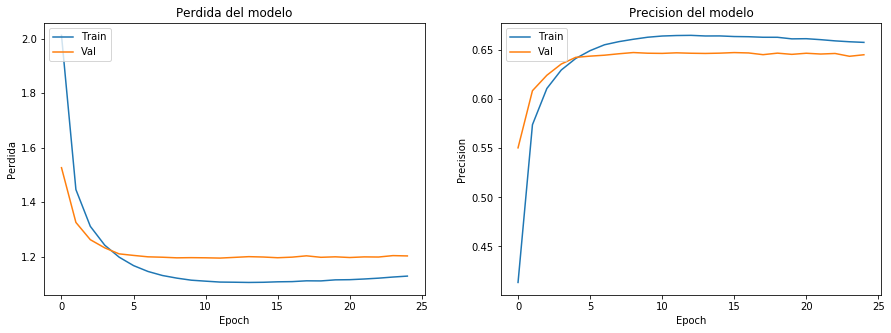

In [50]:
resumenGrafico(history)

Según indican los gráficos, el modelo sufre de overfitting tras 4 epochs aproximadamente, y satura su entrenamiento a los 6 epochs.

Se repite un entrenamiento ahora con solo el 20% del corpus.

In [41]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 5 
sentences = []
next_chars = []
size = int(len(text)*.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
X = sequence.pad_sequences(dataX,maxlen=maxlen+1,padding='pre',value=char_indices[null_character]) 
y = np.asarray([to_categorical(i, num_classes=len(char_indices)) for i in dataY])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

total chars: 72
nb sequences: 242693


In [42]:
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history2=model.fit(X_train, y_train,validation_data=(X_test, y_test),batch_size=256,epochs=25, callbacks=[print_callback])

Train on 169885 samples, validate on 72808 samples
Epoch 1/25
169885/169885 [==============================] - 39s 229us/step - loss: 2.5598 - acc: 0.2651 - val_loss: 2.2296 - val_acc: 0.3351

----- Generating text after Epoch: 0
----- Generating with seed: "magnitude quake on april 6 reduced large"
magnitude quake on april 6 reduced larges , the e5idi. s th the ay . hes testand d kisicg baitind areensirl storias mians s the fordeati n apt . both uniantire in eza. is at 'd . pyor wes ale gillon estusfits of fhos exhams 2f. hahessing t on fage noned-ray an the cto i oplanvy silatin  hoes fry meewre sal ismryian su hedor telone and ere kes wis wille powine a raqob un pertion it avero trht culciditeoins bron the daleited bing hit e noEpoch 2/25
169885/169885 [==============================] - 39s 228us/step - loss: 2.0928 - acc: 0.3808 - val_loss: 1.9400 - val_acc: 0.4239

----- Generating text after Epoch: 1
----- Generating with seed: "he death would be indonesia 's 43rd from"
he death 


----- Generating text after Epoch: 23
----- Generating with seed: "dentify and sanction athletes and coache"
dentify and sanction athletes and coachear desardments . the british tere is under were roused to sso had severe weened mosel . a comples when hell ardicall prices . y on led israel and the united states haifed returnmed ore till and officials to ended impressed months . the news agency says presed in cabas ' was founcis forcicif edoice . those qule a discassed activist and elections in dearly sundical adeau. boadonist and borier thriatEpoch 25/25
169885/169885 [==============================] - 41s 239us/step - loss: 0.6851 - acc: 0.7812 - val_loss: 1.8322 - val_acc: 0.5671

----- Generating text after Epoch: 24
----- Generating with seed: "a and north korea . he said there are re"
a and north korea . he said there are reported presed not coverem leader in iraq keroupharon in 200w , new dething a work of buimdings talks by the torp wordey for president has approve commints on 

Al igual que el modelo anterior, este parece producir palabras que tienen cierta coherencia. De igual manera, puntos y comas son separados por ambos lados con espacios.

In [43]:
model.save("corpus_20.h5")

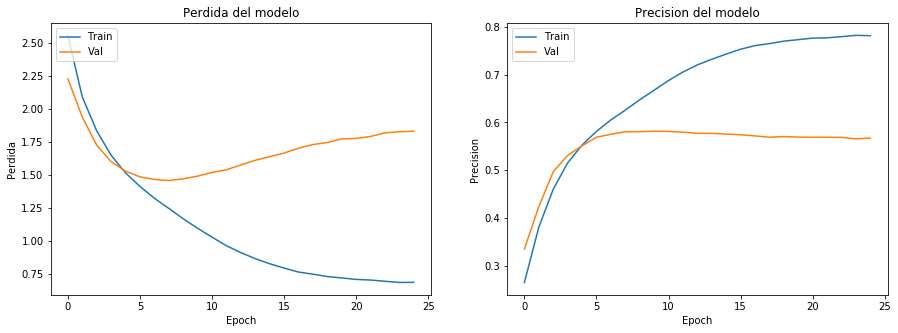

In [49]:
resumenGrafico(history2)

Este modelo también sufre de overfitting a los 4 epochs, pero con una brecha bastante mayor respecto al anterior.

Se procede a comparar lado a lado ambos gráficos.

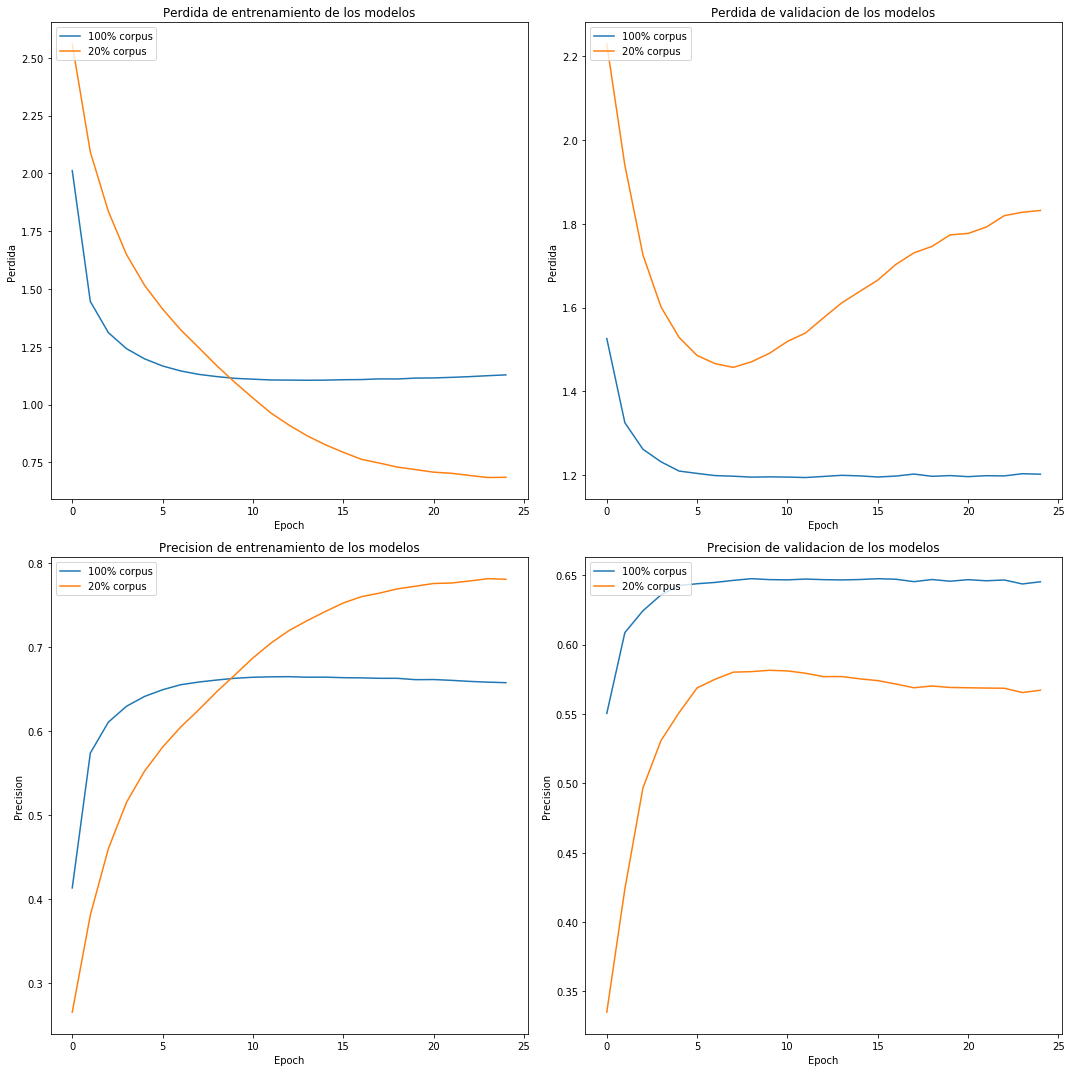

In [53]:
historias=[history,history2]
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
leg=['100% corpus','20% corpus']
for i in range(2):
    ax[0].plot(historias[i].history['loss'])
    ax[1].plot(historias[i].history['val_loss'])
    ax[2].plot(historias[i].history['acc'])
    ax[3].plot(historias[i].history['val_acc'])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper left')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper left')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(leg, loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

De los gráficos se infiere que en validación, utilizar el 100% del corpus significa menos overfitting y mayor precisión del modelo.

> **Parte n)**

In [18]:
from keras.models import load_model
model=load_model("corpus_100.h5")
sentence = " war never changes "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: " war never changes "
 war never changes at the top some detinisting in u.n. department of a senior people and several ameracci could create an inipential are bburancing law voters was held in labelatis on energy sats betant forcings at the official good opening which u.s. on the dumanian president leading in china 's presidential election reconsider his spread of air to the eneggo survey for nearly a proseculation , which is curtely . a

Como ya se vió en el item anterior, la red genera texto con palabras que son reales y frecuentemente inventa otras. Además, el texto generado no tiene mayor coherencia y presenta varios errores ortográficos.

El comportamiento anterior se explica con el método de elección de letras, la función *predict_next_char* selecciona la letra utilizando las probabilidades entregadas por el modelo, por lo que es posible generar palabras con letras improbables, manteniendo cierta consistencia.

Se define una función que selecciona solamente la letra con mayor probabilidad de aparecer.

In [42]:
def predict_next_char2(model, sentence, diversity=1.0):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    maxVal=.0
    index=0
    for i in range(len(preds)):
        if(preds[i]>maxVal):
            maxVal=preds[i]
            index=i
    next_index = index
    return indices_char[next_index]

Luego se genera el texto.

In [47]:
sentence = "war never changes "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char2(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "war never changes "
war never changes and the protest of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests 

Debido a la falta de aleatoridad en la elección de la letra, el modelo fácilmente cae en el error de reproducir la misma línea de texto de manera indefinida, es decir, un loop infinito. Esto sucede con palabras seguidas de conjunciones (that, the, etc), pues como estas conectan distintos tipos de palabras, la posibilidad de que aparezcan es bastante alta.

Como observación adicional, este modo de generación de texto no comete errores ortográficos.

In [52]:
sentence = "harambe is in heaven "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char2(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "harambe is in heaven "
harambe is in heaven are the first time the army since 1999 , and the protest of the country 's president 's political prisoners . the u.s. military says the protest of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests of the protests

Al igual que cualquier máquina determinista, existiendo un loop para cierto input, una vez que entra en él, es imposible salir. Sobretodo para tareas como generación de texto, es muy fácil generar este tipo de loops en base a las probabilidades debido a la estructura sintáctica de los textos.